# d1: Library imports

### Import kaggle

In [ ]:
# 1. Install the Kaggle library
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rayichiu","key":"807d7b2f489606538e9367065b9fcc43"}'}

In [ ]:
# 2. Make a directory named “.kaggle”
! mkdir ~/.kaggle

In [ ]:
# 3. Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [ ]:
# to check the content of directory
! ls ~/.kaggle

kaggle.json


In [ ]:
# 4. Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download dataset from kaggle
# dataset 1 : Netflix TV Shows and Movies
! kaggle datasets download -d victorsoeiro/netflix-tv-shows-and-movies
# dataset 2 : HBO TV Shows and Movies
! kaggle datasets download -d victorsoeiro/hbo-max-tv-shows-and-movies
# dataset 3 : Amazon TV Shows and Movies
! kaggle datasets download -d victorsoeiro/amazon-prime-tv-shows-and-movies
# dataset 4 : Disney TV Shows and Movies
! kaggle datasets download -d victorsoeiro/disney-tv-shows-and-movies

 89% 2.00M/2.25M [00:00<00:00, 2.94MB/s]
100% 2.25M/2.25M [00:00<00:00, 2.83MB/s]
 58% 1.00M/1.71M [00:00<00:00, 1.40MB/s]
100% 1.71M/1.71M [00:00<00:00, 2.14MB/s]
100% 3.76M/3.76M [00:00<00:00, 6.04MB/s]
100% 3.76M/3.76M [00:00<00:00, 4.50MB/s]
100% 718k/718k [00:00<00:00, 1.17MB/s]
100% 718k/718k [00:00<00:00, 1.17MB/s]


In [ ]:
# save them in different directories
# Netflix
! mkdir netflix_raw_data
! unzip netflix-tv-shows-and-movies.zip -d /content/netflix_raw_data
# HBO
! mkdir hbo_raw_data
! unzip hbo-max-tv-shows-and-movies.zip -d /content/hbo_raw_data
# Amazon
! mkdir amazon_raw_data
! unzip amazon-prime-tv-shows-and-movies.zip -d /content/amazon_raw_data
# Disney
! mkdir disney_raw_data
! unzip disney-tv-shows-and-movies.zip -d /content/disney_raw_data

Archive:  netflix-tv-shows-and-movies.zip
  inflating: /content/netflix_raw_data/credits.csv  
  inflating: /content/netflix_raw_data/titles.csv  
Archive:  hbo-max-tv-shows-and-movies.zip
  inflating: /content/hbo_raw_data/credits.csv  
  inflating: /content/hbo_raw_data/titles.csv  
Archive:  amazon-prime-tv-shows-and-movies.zip
  inflating: /content/amazon_raw_data/credits.csv  
  inflating: /content/amazon_raw_data/titles.csv  
Archive:  disney-tv-shows-and-movies.zip
  inflating: /content/disney_raw_data/credits.csv  
  inflating: /content/disney_raw_data/titles.csv  


In [ ]:
# ref : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

### Import file to dataframe

In [ ]:
# Install Bokeh using pip
! pip install bokeh --quiet

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
from collections import defaultdict

# bokeh plot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, LabelSet, Range1d, HoverTool
from bokeh.transform import dodge
from bokeh.palettes import PuOr
from bokeh.layouts import column

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
#install PyMySQL
!pip install PyMySQL --quiet

     |████████████████████████████████| 43 kB 1.5 MB/s 


In [ ]:
#import the cursors class AND the entire pymysql library
import pymysql.cursors
import pymysql

In [ ]:
# import four dataframes
df_netflix = pd.read_csv('./netflix_raw_data/titles.csv')
df_hbo = pd.read_csv('./hbo_raw_data/titles.csv')
df_amazon = pd.read_csv('./amazon_raw_data/titles.csv')
df_disney = pd.read_csv('./disney_raw_data/titles.csv')

In [ ]:
print("Netflix: ", df_netflix.shape)
print("HBO:     ", df_hbo.shape)
print("Amazon:  ", df_amazon.shape)
print("Disney:  ", df_disney.shape)

Netflix:  (5850, 15)
HBO:      (3294, 15)
Amazon:   (9871, 15)
Disney:   (1535, 15)


# d2: Data pre-processing

### Data Source

I use the Netflix/ HBO/ Amazon/ Disney TV Shows and Movies Datasets.  
The URL of the data source is as follows:  
Netflix: https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv  
HBO: https://www.kaggle.com/datasets/victorsoeiro/hbo-max-tv-shows-and-movies?select=titles.csv  
Amazon: https://www.kaggle.com/datasets/victorsoeiro/amazon-prime-tv-shows-and-movies  
Disney: https://www.kaggle.com/datasets/victorsoeiro/disney-tv-shows-and-movies?select=titles.csv  

All the column types are the same across different datasets.
The data has two files, "titles.csv" contains information about TV shows or movies and "credits.csv" contains the actor and directors data. Important columns include title, type, genre, production_countries and imdb_score. In this project, I only use the titles.csv in every dataset to investigate production distribution across different stream providers. 

### Remove NAs and duplicate columns

In [ ]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        df = df.to_frame()
        df.columns = [caption]
        output += df.style.set_table_attributes("style='display:inline'")._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [ ]:
def display_NA_dfs():
    na_stat_netflix = df_netflix.isna().sum()
    na_stat_hbo = df_hbo.isna().sum()
    na_stat_amazon = df_amazon.isna().sum()
    na_stat_disney = df_disney.isna().sum()
    display_side_by_side([na_stat_netflix, na_stat_hbo, na_stat_amazon, na_stat_disney], 
                        ['NA Stat Netflix', 'NA Stat HBO', 'NA Stat Amazon', 'NA Stat Disney'])
display_NA_dfs()

,NA Stat Netflix
id,0
title,1
type,0
description,18
release_year,0
age_certification,2619
runtime,0
genres,0
production_countries,0
seasons,3744


In [ ]:
def clean_dataset(dataframe):
  # drop the row which contains na value in title and description column
  dataframe.dropna(axis = 0, subset=["title", "description"], inplace = True)
  # drop non useful columns
  dataframe.drop(['age_certification', 'seasons', 'imdb_id', 'id', 'imdb_votes', \
                  'tmdb_popularity', 'tmdb_score', 'description'], axis=1, inplace=True)
  # fill the na value with mean value in the following columns
  dataframe["imdb_score"] = dataframe["imdb_score"].fillna(value = dataframe["imdb_score"].mean())

In [ ]:
dfs = [df_netflix, df_hbo, df_amazon, df_disney]
for dataframe in dfs:
  clean_dataset(dataframe)

In [ ]:
display_NA_dfs()

,NA Stat Netflix
title,0
type,0
release_year,0
runtime,0
genres,0
production_countries,0
imdb_score,0
,NA Stat HBO
title,0
type,0


In [ ]:
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832 entries, 0 to 5849
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 5832 non-null   object 
 1   type                  5832 non-null   object 
 2   release_year          5832 non-null   int64  
 3   runtime               5832 non-null   int64  
 4   genres                5832 non-null   object 
 5   production_countries  5832 non-null   object 
 6   imdb_score            5832 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 364.5+ KB


In [ ]:
# drop duplicate values if any
dfs = [df_netflix, df_hbo, df_amazon, df_disney]
for dataframe in dfs:
  dataframe = dataframe.drop_duplicates()

In [ ]:
df_netflix.head(3)

,title,type,release_year,runtime,genres,production_countries,imdb_score
0,Five Came Back: The Reference Films,SHOW,1945,51,['documentation'],['US'],6.511225
1,Taxi Driver,MOVIE,1976,114,"['drama', 'crime']",['US'],8.200000
2,Deliverance,MOVIE,1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.700000


### Unpack genres

The column genres is actually a string, even though it looks like a list (ex: ['documentation'] or [drama, crime]). Besides, it may contain more than one genres, since a production may contain multi genres.
Therefore, I need to unpack this column and assign the genre as True in the corresponding type of genre columns. 

In [ ]:
print(df_netflix["genres"].iloc[0])
print(type(df_netflix["genres"].iloc[0]))

['documentation']
<class 'str'>


In [ ]:
# ref https://www.kaggle.com/code/nahidahsan/amazon-data-visualization-and-recomendation
# every cell is converted to a list of genres
def unpack_genres(dfs):
  genres = []
  for dataframe in dfs:
    dataframe["genres"] = dataframe["genres"].apply(lambda x: re.findall("\w+", x))
    # print(dataframe["genres"].head(5))
    # print(type(dataframe["genres"].iloc[0]))
    # print(dataframe["genres"].iloc[0][0])
    # print(type(dataframe["genres"].iloc[0][0]))

    # convert all the cells in this column into np array
    genres = list(dataframe["genres"].values)
    genres = list(set([item for sublist in genres for item in sublist]))

    for i, genre in enumerate(genres):
        dataframe[genre] = dataframe.genres.apply(lambda x: 1 if genre in x else 0).astype(int)
  return genres

dfs = [df_netflix, df_hbo, df_amazon, df_disney]
genres = unpack_genres(dfs)

print("Number of Genres: ", len(genres))
print("Genres:", genres)

Number of Genres:  19
Genres: ['music', 'family', 'western', 'comedy', 'fantasy', 'crime', 'war', 'documentation', 'romance', 'reality', 'sport', 'horror', 'history', 'scifi', 'action', 'animation', 'thriller', 'drama', 'european']


In [ ]:
# show the first row
df_netflix.iloc[0][:]

title                   Five Came Back: The Reference Films
type                                                   SHOW
release_year                                           1945
runtime                                                  51
genres                                      [documentation]
production_countries                                 ['US']
imdb_score                                         6.511225
music                                                     0
western                                                   0
family                                                    0
comedy                                                    0
fantasy                                                   0
crime                                                     0
war                                                       0
documentation                                             1
romance                                                   0
reality                                 

In [ ]:
# change column names drop genres column
for dataframe in dfs:
  for old_col in genres:
    dataframe.rename(columns = {old_col:'genre_' + old_col}, inplace = True)
  dataframe.drop(['genres'], axis=1, inplace=True)

In [ ]:
# show the first row
df_netflix.iloc[0][:]

title                   Five Came Back: The Reference Films
type                                                   SHOW
release_year                                           1945
runtime                                                  51
production_countries                                 ['US']
imdb_score                                         6.511225
genre_music                                               0
genre_western                                             0
genre_family                                              0
genre_comedy                                              0
genre_fantasy                                             0
genre_crime                                               0
genre_war                                                 0
genre_documentation                                       1
genre_romance                                             0
genre_reality                                             0
genre_sport                             

### Unpack countries

Similar as genres, the column production_countries is also a string, even though it looks like a list (ex: ['US']). Besides, it may contain more than one countries, since a production may produced by team in different countries. Therefore, I need to unpack this column and assign the country as True in the corresponding country columns. Since there are 109 countries, I just choose the top 10 countries in Netflix database to create the country column.

In [ ]:
print(df_netflix["production_countries"].iloc[0])
print(type(df_netflix["production_countries"].iloc[0]))

['US']
<class 'str'>


In [ ]:
for dataframe in dfs:
  dataframe["production_countries"] = dataframe["production_countries"].apply(lambda x: re.findall("\w+", x))
production_countries = list(df_netflix["production_countries"].values)
production_countries = list(set([item for sublist in production_countries for item in sublist]))

In [ ]:
print(production_countries)
print(len(production_countries))

['QA', 'MW', 'NA', 'FR', 'RS', 'EG', 'CH', 'NP', 'PL', 'IO', 'BS', 'IR', 'CZ', 'MA', 'GL', 'VA', 'DE', 'LK', 'CN', 'BT', 'GH', 'KG', 'FI', 'PS', 'AU', 'JO', 'CM', 'NO', 'SA', 'BF', 'MY', 'HU', 'CA', 'TZ', 'SG', 'KW', 'IS', 'PY', 'ES', 'TN', 'KH', 'CO', 'BY', 'AF', 'BD', 'IE', 'AR', 'BR', 'CU', 'LU', 'RO', 'FO', 'GB', 'HR', 'GE', 'PH', 'MX', 'UY', 'NZ', 'IT', 'PT', 'US', 'PR', 'IQ', 'IL', 'TH', 'RU', 'MC', 'BE', 'ZA', 'KR', 'AT', 'SN', 'SE', 'HK', 'Lebanon', 'SY', 'VN', 'LB', 'SU', 'TR', 'ID', 'GT', 'NL', 'CD', 'PK', 'LT', 'DK', 'AE', 'XX', 'TW', 'VE', 'JP', 'MT', 'BG', 'AL', 'DZ', 'MU', 'NG', 'CY', 'GR', 'ZW', 'UA', 'KE', 'AO', 'IN', 'KN', 'CL', 'PE']
109


In [ ]:
# find out the top 10 countries and create the country column
prod_countries_cnt = defaultdict(int)

for country in production_countries:
   prod_countries_cnt[country] = 0

for _, country_list in df_netflix["production_countries"].iteritems():
  # print(country_list)
  for country in country_list:
    prod_countries_cnt[country] += 1

prod_countries_cnt = sorted(prod_countries_cnt.items(), key = lambda kv: kv[1], reverse=True)
prod_countries_cnt = prod_countries_cnt[:10]

for dataframe in dfs:
  for i, country_tuple in enumerate(prod_countries_cnt):
      country = country_tuple[0]
      dataframe[country] = dataframe.production_countries.apply(lambda x: 1 if country in x else 0).astype(int)

print("Number of production_countries: ", len(production_countries))
print("production_countries:", production_countries)
print("production_countries_count", prod_countries_cnt)

Number of production_countries:  109
production_countries: ['QA', 'MW', 'NA', 'FR', 'RS', 'EG', 'CH', 'NP', 'PL', 'IO', 'BS', 'IR', 'CZ', 'MA', 'GL', 'VA', 'DE', 'LK', 'CN', 'BT', 'GH', 'KG', 'FI', 'PS', 'AU', 'JO', 'CM', 'NO', 'SA', 'BF', 'MY', 'HU', 'CA', 'TZ', 'SG', 'KW', 'IS', 'PY', 'ES', 'TN', 'KH', 'CO', 'BY', 'AF', 'BD', 'IE', 'AR', 'BR', 'CU', 'LU', 'RO', 'FO', 'GB', 'HR', 'GE', 'PH', 'MX', 'UY', 'NZ', 'IT', 'PT', 'US', 'PR', 'IQ', 'IL', 'TH', 'RU', 'MC', 'BE', 'ZA', 'KR', 'AT', 'SN', 'SE', 'HK', 'Lebanon', 'SY', 'VN', 'LB', 'SU', 'TR', 'ID', 'GT', 'NL', 'CD', 'PK', 'LT', 'DK', 'AE', 'XX', 'TW', 'VE', 'JP', 'MT', 'BG', 'AL', 'DZ', 'MU', 'NG', 'CY', 'GR', 'ZW', 'UA', 'KE', 'AO', 'IN', 'KN', 'CL', 'PE']
production_countries_count [('US', 2320), ('IN', 622), ('GB', 404), ('JP', 284), ('FR', 248), ('KR', 226), ('CA', 219), ('ES', 210), ('DE', 139), ('MX', 126)]


In [ ]:
df_netflix.iloc[0][:]

title                   Five Came Back: The Reference Films
type                                                   SHOW
release_year                                           1945
runtime                                                  51
production_countries                                   [US]
imdb_score                                         6.511225
genre_music                                               0
genre_western                                             0
genre_family                                              0
genre_comedy                                              0
genre_fantasy                                             0
genre_crime                                               0
genre_war                                                 0
genre_documentation                                       1
genre_romance                                             0
genre_reality                                             0
genre_sport                             

In [ ]:
# change column names
for dataframe in dfs:
  for i, country_tuple in enumerate(prod_countries_cnt):
      country = country_tuple[0]
      dataframe.rename(columns = {country :'country_' + country}, inplace = True)
  dataframe.drop(['production_countries'], axis=1, inplace=True)

In [ ]:
df_netflix.iloc[0][:]

title                  Five Came Back: The Reference Films
type                                                  SHOW
release_year                                          1945
runtime                                                 51
imdb_score                                        6.511225
genre_music                                              0
genre_western                                            0
genre_family                                             0
genre_comedy                                             0
genre_fantasy                                            0
genre_crime                                              0
genre_war                                                0
genre_documentation                                      1
genre_romance                                            0
genre_reality                                            0
genre_sport                                              0
genre_horror                                            

### drop duplicate columns and rename columns 

In [ ]:
# rename column type since type is the key word in python
dfs = [df_netflix, df_hbo, df_amazon, df_disney]
for dataframe in dfs:
  dataframe.rename(columns = {'type' : 'product_type'}, inplace = True)

In [ ]:
# no duplicate rows
bool_series = df_netflix.duplicated()
df_netflix[bool_series]

,title,product_type,release_year,runtime,imdb_score,genre_music,genre_western,genre_family,genre_comedy,genre_fantasy,...,country_US,country_IN,country_GB,country_JP,country_FR,country_KR,country_CA,country_ES,country_DE,country_MX


### Subset. Select the only those columns you wish to work with

Four dataframes are clean enough, all the non necessary columns are dropped.
They don't need to be subsetted.

In [ ]:
df_netflix.iloc[0][:]

title                  Five Came Back: The Reference Films
product_type                                          SHOW
release_year                                          1945
runtime                                                 51
imdb_score                                        6.511225
genre_music                                              0
genre_western                                            0
genre_family                                             0
genre_comedy                                             0
genre_fantasy                                            0
genre_crime                                              0
genre_war                                                0
genre_documentation                                      1
genre_romance                                            0
genre_reality                                            0
genre_sport                                              0
genre_horror                                            

In [ ]:
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832 entries, 0 to 5849
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                5832 non-null   object 
 1   product_type         5832 non-null   object 
 2   release_year         5832 non-null   int64  
 3   runtime              5832 non-null   int64  
 4   imdb_score           5832 non-null   float64
 5   genre_music          5832 non-null   int64  
 6   genre_western        5832 non-null   int64  
 7   genre_family         5832 non-null   int64  
 8   genre_comedy         5832 non-null   int64  
 9   genre_fantasy        5832 non-null   int64  
 10  genre_crime          5832 non-null   int64  
 11  genre_war            5832 non-null   int64  
 12  genre_documentation  5832 non-null   int64  
 13  genre_romance        5832 non-null   int64  
 14  genre_reality        5832 non-null   int64  
 15  genre_sport          5832 non-null   i

In [ ]:
df_netflix.describe()

,release_year,runtime,imdb_score,genre_music,genre_western,genre_family,genre_comedy,genre_fantasy,genre_crime,genre_war,...,country_US,country_IN,country_GB,country_JP,country_FR,country_KR,country_CA,country_ES,country_DE,country_MX
count,"5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00",...,"5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00","5,832.00"
mean,"2,016.41",76.99,6.51,0.04,0.01,0.12,0.40,0.11,0.16,0.03,...,0.40,0.11,0.07,0.05,0.04,0.04,0.04,0.04,0.02,0.02
std,6.95,38.99,1.12,0.21,0.08,0.32,0.49,0.31,0.37,0.16,...,0.49,0.31,0.25,0.22,0.20,0.19,0.19,0.19,0.15,0.15
min,"1,945.00",0.00,1.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"2,016.00",44.00,5.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"2,018.00",83.00,6.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,"2,020.00",105.00,7.30,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,"2,022.00",240.00,9.60,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


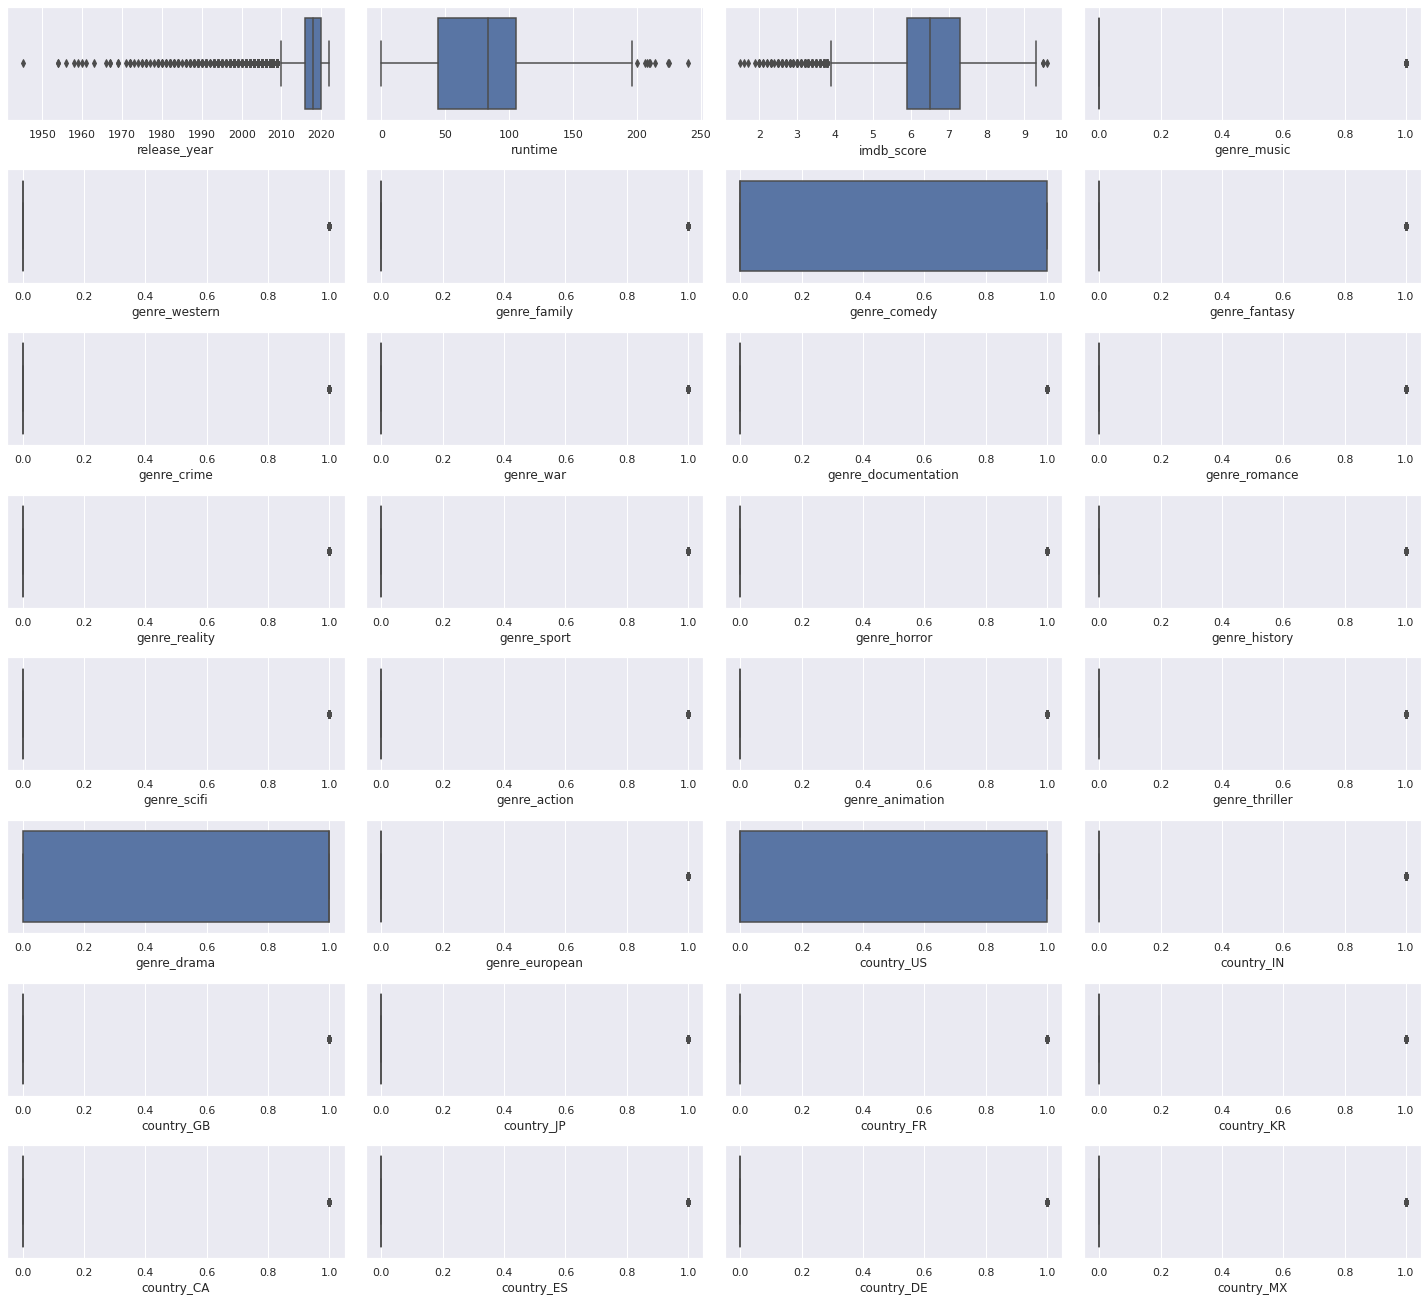

In [ ]:
# check the outliers 
plt.figure(figsize = (20, 20))
x = 1 

for column in df_netflix.describe().columns:
    plt.subplot(9,4,x)
    sns.boxplot(df_netflix[column])
    x+=1
    
plt.tight_layout()

In [ ]:
# find the runtime significantly longer
df_netflix[df_netflix['runtime'] > 200]

,title,product_type,release_year,runtime,imdb_score,genre_music,genre_western,genre_family,genre_comedy,genre_fantasy,...,country_US,country_IN,country_GB,country_JP,country_FR,country_KR,country_CA,country_ES,country_DE,country_MX
166,Hum Aapke Hain Koun..!,MOVIE,1994,206,7.50,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
347,Lagaan: Once Upon a Time in India,MOVIE,2001,224,8.10,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
351,No Direction Home: Bob Dylan,MOVIE,2005,208,6.51,1,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
406,Kabhi Khushi Kabhie Gham,MOVIE,2001,210,7.40,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
412,Jodhaa Akbar,MOVIE,2008,214,7.50,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
438,A Lion in the House,MOVIE,2006,225,8.70,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
923,Bonnie & Clyde,MOVIE,2013,240,6.51,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3076,The Irishman,MOVIE,2019,209,7.80,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# d3: Inserting the data

### Create database and tables(s)

In [ ]:
df_netflix.columns

Index(['title', 'product_type', 'release_year', 'runtime', 'imdb_score',
       'genre_music', 'genre_western', 'genre_family', 'genre_comedy',
       'genre_fantasy', 'genre_crime', 'genre_war', 'genre_documentation',
       'genre_romance', 'genre_reality', 'genre_sport', 'genre_horror',
       'genre_history', 'genre_scifi', 'genre_action', 'genre_animation',
       'genre_thriller', 'genre_drama', 'genre_european', 'country_US',
       'country_IN', 'country_GB', 'country_JP', 'country_FR', 'country_KR',
       'country_CA', 'country_ES', 'country_DE', 'country_MX'],
      dtype='object')

In [ ]:
#create your table using MySQL WorkBench.
#create a create_table.sql script that includes something like the following: (omit the ''')

'''
-- DROP DATABASE movies;
CREATE DATABASE movies;
USE movies;

DROP TABLE netflix;
CREATE TABLE netflix (
       id INT PRIMARY KEY AUTO_INCREMENT,
       title VARCHAR(255), 
       product_type  VARCHAR(255),  
       -- film_description VARCHAR(255), 
       release_year INT, 
       runtime INT, 
       imdb_score FLOAT,

       genre_crime BOOL,
       genre_family BOOL,
       genre_history BOOL,
       genre_animation BOOL,
       genre_western BOOL,
       genre_music BOOL,
       genre_war BOOL,
       genre_romance BOOL,
       genre_scifi BOOL,
       genre_drama BOOL,
       genre_sport BOOL,
       genre_reality BOOL,
       genre_thriller BOOL,
       genre_action BOOL,
       genre_comedy BOOL,
       genre_documentation BOOL,
       genre_european BOOL,
       genre_horror BOOL,
       genre_fantasy BOOL,
       country_US BOOL,
       country_IN BOOL,
       country_GB BOOL,
       country_JP BOOL,
       country_FR BOOL,
       country_KR BOOL,
       country_CA BOOL,
       country_ES BOOL,
       country_DE BOOL,
       country_MX BOOL
); 
'''

'\n-- DROP DATABASE movies;\nCREATE DATABASE movies;\nUSE movies;\n\nDROP TABLE netflix;\nCREATE TABLE netflix (\n       id INT PRIMARY KEY AUTO_INCREMENT,\n       title VARCHAR(255), \n       product_type  VARCHAR(255),  \n       -- film_description VARCHAR(255), \n       release_year INT, \n       runtime INT, \n       imdb_score FLOAT,\n\n       genre_crime BOOL,\n       genre_family BOOL,\n       genre_history BOOL,\n       genre_animation BOOL,\n       genre_western BOOL,\n       genre_music BOOL,\n       genre_war BOOL,\n       genre_romance BOOL,\n       genre_scifi BOOL,\n       genre_drama BOOL,\n       genre_sport BOOL,\n       genre_reality BOOL,\n       genre_thriller BOOL,\n       genre_action BOOL,\n       genre_comedy BOOL,\n       genre_documentation BOOL,\n       genre_european BOOL,\n       genre_horror BOOL,\n       genre_fantasy BOOL,\n       country_US BOOL,\n       country_IN BOOL,\n       country_GB BOOL,\n       country_JP BOOL,\n       country_FR BOOL,\n       

### Via python, connect to your database insert rows

In [ ]:
#connect to your db
connection = pymysql.connect(host='34.28.158.198',
                             user='root',
                             password='Teddy@19910908',
                             db='movies', ##add your schema name here
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

In [ ]:
# insert df_netflix

for i,row in df_netflix.iterrows(): 
    title = row['title'],
    product_type = row['product_type'], 
    # film_description = row['film_description'], 
    release_year = int(row['release_year']), 
    runtime = int(row['runtime']), 
    imdb_score = float(row['imdb_score']),

    genre_crime = bool(row['genre_crime']),
    genre_family = bool(row['genre_family']),
    genre_history = bool(row['genre_history']),
    genre_animation = bool(row['genre_animation']),
    genre_western = bool(row['genre_western']),
    genre_music = bool(row['genre_music']),
    genre_war = bool(row['genre_war']),
    genre_romance = bool(row['genre_romance']),
    genre_scifi = bool(row['genre_scifi']),
    genre_drama = bool(row['genre_drama']),
    genre_sport = bool(row['genre_sport']),
    genre_reality = bool(row['genre_reality']),
    genre_thriller = bool(row['genre_thriller']),
    genre_action = bool(row['genre_action']),
    genre_comedy = bool(row['genre_comedy']),
    genre_documentation = bool(row['genre_documentation']),
    genre_european = bool(row['genre_european']),
    genre_horror = bool(row['genre_horror']),
    genre_fantasy = bool(row['genre_fantasy']),
    country_US = bool(row['country_US']),
    country_IN = bool(row['country_IN']),
    country_GB = bool(row['country_GB']),
    country_JP = bool(row['country_JP']),
    country_FR = bool(row['country_FR']),
    country_KR = bool(row['country_KR']),
    country_CA = bool(row['country_CA']),
    country_ES = bool(row['country_ES']),
    country_DE = bool(row['country_DE']),
    country_MX = bool(row['country_MX'])

    # print(title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
    # genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
    # genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX)

    # print("Inserting school")
    # query_template ="INSERT INTO schools (Rank1, School,Country, AvgSalary, PreSalary,GradJobs) VALUES(%s,%s, %s, %s, %s,%s)"

    query_template ="INSERT INTO netflix (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
    genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
    genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX) \
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s)"

    query_parameters = (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
        genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
        genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX)
    cursor.execute(query_template, query_parameters)
    connection.commit() 

In [ ]:
# insert df_hbo

for i,row in df_hbo.iterrows(): 
    title = row['title'],
    product_type = row['product_type'], 
    # film_description = row['film_description'], 
    release_year = int(row['release_year']), 
    runtime = int(row['runtime']), 
    imdb_score = float(row['imdb_score']),

    genre_crime = bool(row['genre_crime']),
    genre_family = bool(row['genre_family']),
    genre_history = bool(row['genre_history']),
    genre_animation = bool(row['genre_animation']),
    genre_western = bool(row['genre_western']),
    genre_music = bool(row['genre_music']),
    genre_war = bool(row['genre_war']),
    genre_romance = bool(row['genre_romance']),
    genre_scifi = bool(row['genre_scifi']),
    genre_drama = bool(row['genre_drama']),
    genre_sport = bool(row['genre_sport']),
    genre_reality = bool(row['genre_reality']),
    genre_thriller = bool(row['genre_thriller']),
    genre_action = bool(row['genre_action']),
    genre_comedy = bool(row['genre_comedy']),
    genre_documentation = bool(row['genre_documentation']),
    genre_european = bool(row['genre_european']),
    genre_horror = bool(row['genre_horror']),
    genre_fantasy = bool(row['genre_fantasy']),
    country_US = bool(row['country_US']),
    country_IN = bool(row['country_IN']),
    country_GB = bool(row['country_GB']),
    country_JP = bool(row['country_JP']),
    country_FR = bool(row['country_FR']),
    country_KR = bool(row['country_KR']),
    country_CA = bool(row['country_CA']),
    country_ES = bool(row['country_ES']),
    country_DE = bool(row['country_DE']),
    country_MX = bool(row['country_MX'])

    query_template ="INSERT INTO hbo (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
    genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
    genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX) \
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s)"

    query_parameters = (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
        genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
        genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX)
    cursor.execute(query_template, query_parameters)
    connection.commit() 

In [ ]:
# insert df_amazon

for i,row in df_amazon.iterrows(): 
    title = row['title'],
    product_type = row['product_type'], 
    # film_description = row['film_description'], 
    release_year = int(row['release_year']), 
    runtime = int(row['runtime']), 
    imdb_score = float(row['imdb_score']),

    genre_crime = bool(row['genre_crime']),
    genre_family = bool(row['genre_family']),
    genre_history = bool(row['genre_history']),
    genre_animation = bool(row['genre_animation']),
    genre_western = bool(row['genre_western']),
    genre_music = bool(row['genre_music']),
    genre_war = bool(row['genre_war']),
    genre_romance = bool(row['genre_romance']),
    genre_scifi = bool(row['genre_scifi']),
    genre_drama = bool(row['genre_drama']),
    genre_sport = bool(row['genre_sport']),
    genre_reality = bool(row['genre_reality']),
    genre_thriller = bool(row['genre_thriller']),
    genre_action = bool(row['genre_action']),
    genre_comedy = bool(row['genre_comedy']),
    genre_documentation = bool(row['genre_documentation']),
    genre_european = bool(row['genre_european']),
    genre_horror = bool(row['genre_horror']),
    genre_fantasy = bool(row['genre_fantasy']),
    country_US = bool(row['country_US']),
    country_IN = bool(row['country_IN']),
    country_GB = bool(row['country_GB']),
    country_JP = bool(row['country_JP']),
    country_FR = bool(row['country_FR']),
    country_KR = bool(row['country_KR']),
    country_CA = bool(row['country_CA']),
    country_ES = bool(row['country_ES']),
    country_DE = bool(row['country_DE']),
    country_MX = bool(row['country_MX'])

    query_template ="INSERT INTO amazon (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
    genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
    genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX) \
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s)"

    query_parameters = (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
        genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
        genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX)
    cursor.execute(query_template, query_parameters)
    connection.commit() 

In [ ]:
# insert df_disney

for i,row in df_disney.iterrows(): 
    title = row['title'],
    product_type = row['product_type'], 
    # film_description = row['film_description'], 
    release_year = int(row['release_year']), 
    runtime = int(row['runtime']), 
    imdb_score = float(row['imdb_score']),

    genre_crime = bool(row['genre_crime']),
    genre_family = bool(row['genre_family']),
    genre_history = bool(row['genre_history']),
    genre_animation = bool(row['genre_animation']),
    genre_western = bool(row['genre_western']),
    genre_music = bool(row['genre_music']),
    genre_war = bool(row['genre_war']),
    genre_romance = bool(row['genre_romance']),
    genre_scifi = bool(row['genre_scifi']),
    genre_drama = bool(row['genre_drama']),
    genre_sport = bool(row['genre_sport']),
    genre_reality = bool(row['genre_reality']),
    genre_thriller = bool(row['genre_thriller']),
    genre_action = bool(row['genre_action']),
    genre_comedy = bool(row['genre_comedy']),
    genre_documentation = bool(row['genre_documentation']),
    genre_european = bool(row['genre_european']),
    genre_horror = bool(row['genre_horror']),
    genre_fantasy = bool(row['genre_fantasy']),
    country_US = bool(row['country_US']),
    country_IN = bool(row['country_IN']),
    country_GB = bool(row['country_GB']),
    country_JP = bool(row['country_JP']),
    country_FR = bool(row['country_FR']),
    country_KR = bool(row['country_KR']),
    country_CA = bool(row['country_CA']),
    country_ES = bool(row['country_ES']),
    country_DE = bool(row['country_DE']),
    country_MX = bool(row['country_MX'])

    query_template ="INSERT INTO disney (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
    genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
    genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX) \
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
           %s, %s, %s, %s)"

    query_parameters = (title,	product_type,	release_year,	runtime,	imdb_score,	genre_crime, genre_family,	genre_history, genre_animation,	genre_western,	genre_music, \
        genre_war,	genre_romance,	genre_scifi,	genre_drama, genre_sport,	genre_reality, genre_thriller,	genre_action,	genre_comedy,	genre_documentation,	genre_european, \
        genre_horror,	genre_fantasy,	country_US,	country_IN,	country_GB,	country_JP, country_FR,	country_KR,	country_CA,	country_ES,	country_DE,	country_MX)
    cursor.execute(query_template, query_parameters)
    connection.commit() 

### Convert query to dataframe

In [ ]:
# netflix
sql_netflix = "SELECT * from netflix"
cursor.execute(sql_netflix)
result_netflix = cursor.fetchall()

# # hbo
# sql_hbo = "SELECT * from hbo"
# cursor.execute(sql_hbo)
# result_hbo = cursor.fetchall()

# # amazon
# sql_amazon = "SELECT * from amazon"
# cursor.execute(sql_amazon)
# result_amazon = cursor.fetchall()

# # disney
# sql_disney = "SELECT * from disney"
# cursor.execute(sql_disney)
# result_disney = cursor.fetchall()

In [ ]:
df = pd.DataFrame(result_netflix)
df

,id,title,product_type,release_year,runtime,imdb_score,genre_crime,genre_family,genre_history,genre_animation,...,country_US,country_IN,country_GB,country_JP,country_FR,country_KR,country_CA,country_ES,country_DE,country_MX
0,1,Five Came Back: The Reference Films,SHOW,1945,51,6.51123,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Taxi Driver,MOVIE,1976,114,8.20000,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Deliverance,MOVIE,1972,109,7.70000,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,Monty Python and the Holy Grail,MOVIE,1975,91,8.20000,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,5,The Dirty Dozen,MOVIE,1967,150,7.70000,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,5828,Fine Wine,MOVIE,2021,100,6.80000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5828,5829,C/O Kaadhal,MOVIE,2021,134,7.70000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829,5830,Lokillo,MOVIE,2021,90,3.80000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5830,5831,Dad Stop Embarrassing Me - The Afterparty,MOVIE,2021,37,6.51123,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_netflix.iloc[0][:]

title                  Five Came Back: The Reference Films
product_type                                          SHOW
release_year                                          1945
runtime                                                 51
imdb_score                                        6.511225
genre_music                                              0
genre_western                                            0
genre_family                                             0
genre_comedy                                             0
genre_fantasy                                            0
genre_crime                                              0
genre_war                                                0
genre_documentation                                      1
genre_romance                                            0
genre_reality                                            0
genre_sport                                              0
genre_horror                                            

### Close cursor

Do not close the cursor here! In d4 we will need to use sql query to analyze data. But need to close it after all the SQL queries.

In [ ]:
cursor.close() #close your connection.

# d4: Data analysis

### Q1: What is the count of movies and TV shows across different service providers (different datasets)?

In [ ]:
# SQL Query code
# netflix
sql = """SELECT count(id) as movie_count FROM netflix 
       WHERE product_type = 'Movie'"""
cursor.execute(sql)
result = cursor.fetchall()
netflix_movie_cnt = result[0]["movie_count"]

sql = """SELECT count(id) as tv_count FROM netflix 
       WHERE product_type = 'SHOW'"""
cursor.execute(sql)
result = cursor.fetchall()
netflix_tv_cnt = result[0]["tv_count"]

# hbo
sql = """SELECT count(id) as movie_count FROM hbo 
       WHERE product_type = 'Movie'"""
cursor.execute(sql)
result = cursor.fetchall()
hbo_movie_cnt = result[0]["movie_count"]

sql = """SELECT count(id) as tv_count FROM hbo 
       WHERE product_type = 'SHOW'"""
cursor.execute(sql)
result = cursor.fetchall()
hbo_tv_cnt = result[0]["tv_count"]

# amazon
sql = """SELECT count(id) as movie_count FROM amazon 
       WHERE product_type = 'Movie'"""
cursor.execute(sql)
result = cursor.fetchall()
amazon_movie_cnt = result[0]["movie_count"]

sql = """SELECT count(id) as tv_count FROM amazon 
       WHERE product_type = 'SHOW'"""
cursor.execute(sql)
result = cursor.fetchall()
amazon_tv_cnt = result[0]["tv_count"]

# disney
sql = """SELECT count(id) as movie_count FROM disney 
       WHERE product_type = 'Movie'"""
cursor.execute(sql)
result = cursor.fetchall()
disney_movie_cnt = result[0]["movie_count"]

sql = """SELECT count(id) as tv_count FROM disney 
       WHERE product_type = 'SHOW'"""
cursor.execute(sql)
result = cursor.fetchall()
disney_tv_cnt = result[0]["tv_count"]

In [ ]:
product_type_col = ["Movie", "Show"]
provider = ["Netflix", "HBO", "Amazon", "Disney"]

# # instead of using SQL, here is the code of using pandas directly 
# # downwards is the code of using pandas libraries
# data_movie_show = {"product_type_col" : product_type_col,
#                    "Netflix" : [df_netflix['product_type'].value_counts()["MOVIE"], df_netflix['product_type'].value_counts()["SHOW"]],
#                    "HBO" : [df_hbo['product_type'].value_counts()["MOVIE"], df_hbo['product_type'].value_counts()["SHOW"]],
#                    "Amazon" : [df_amazon['product_type'].value_counts()["MOVIE"], df_amazon['product_type'].value_counts()["SHOW"]],
#                    "Disney" : [df_disney['product_type'].value_counts()["MOVIE"], df_disney['product_type'].value_counts()["SHOW"]]}

data_movie_show = {"product_type_col" : product_type_col,
                   "Netflix" : [netflix_movie_cnt, netflix_tv_cnt],
                   "HBO" : [hbo_movie_cnt, hbo_tv_cnt],
                   "Amazon" : [amazon_movie_cnt, amazon_tv_cnt],
                   "Disney" : [disney_movie_cnt, disney_tv_cnt]}

In [ ]:
data_movie_show

{'product_type_col': ['Movie', 'Show'],
 'Netflix': [3735, 2097],
 'HBO': [2528, 754],
 'Amazon': [8426, 1326],
 'Disney': [1118, 411]}

### Q2: What are the best comedy movies in each dataset? (Find the top five IMDB Rating comedy movies in each dataset)

In [ ]:
# netflix
sql = """SELECT title, release_year, imdb_score FROM netflix 
       WHERE genre_comedy = True AND product_type = 'Movie'
       ORDER BY imdb_score DESC
       LIMIT 5"""
cursor.execute(sql)
result = cursor.fetchall()
df_top5_comedy_netflix = pd.DataFrame(result)

# hbo
sql = """SELECT title, release_year, imdb_score FROM hbo 
       WHERE genre_comedy = True AND product_type = 'Movie'
       ORDER BY imdb_score DESC
       LIMIT 5"""
cursor.execute(sql)
result = cursor.fetchall()
df_top5_comedy_hbo = pd.DataFrame(result)

# amazon
sql = """SELECT title, release_year, imdb_score FROM amazon 
       WHERE genre_comedy = True AND product_type = 'Movie'
       ORDER BY imdb_score DESC
       LIMIT 5"""
cursor.execute(sql)
result = cursor.fetchall()
df_top5_comedy_amazon = pd.DataFrame(result)

# disney
sql = """SELECT title, release_year, imdb_score FROM disney 
       WHERE genre_comedy = True AND product_type = 'Movie'
       ORDER BY imdb_score DESC
       LIMIT 5"""
cursor.execute(sql)
result = cursor.fetchall()
df_top5_comedy_disney = pd.DataFrame(result)

In [ ]:
# # instead of using SQL, here is the code of using pandas directly 
# # downwards is the code of using pandas libraries

# df_netflix_sort = df_netflix[(df_netflix["genre_comedy"] == 1) & (df_netflix["product_type"] == "MOVIE")] \
#     .sort_values(by=['imdb_score'], ascending=False)
# df_netflix_sort[["title", "release_year", "imdb_score"]].iloc[:5]

# df_hbo_sort = df_hbo[(df_hbo["genre_comedy"] == 1) & (df_hbo["product_type"] == "MOVIE")] \
#     .sort_values(by=['imdb_score'], ascending=False)
# df_hbo_sort[["title", "release_year", "imdb_score"]].iloc[:5]

### Q3: What is the trend of release number for all the productions in each dataset from 1980 to 2022?

In [ ]:
# netflix
sql = """SELECT release_year, count(id) as release_count FROM netflix 
       WHERE release_year BETWEEN 1980 AND 2022
       GROUP BY release_year
       ORDER BY release_year
       """

cursor.execute(sql)
result = cursor.fetchall()
df_release_num_netflix = pd.DataFrame(result)

# hbo
sql = """SELECT release_year, count(id) as release_count FROM hbo 
       WHERE release_year BETWEEN 1980 AND 2022
       GROUP BY release_year
       ORDER BY release_year
       """

cursor.execute(sql)
result = cursor.fetchall()
df_release_num_hbo = pd.DataFrame(result)

# amazon
sql = """SELECT release_year, count(id) as release_count FROM amazon 
       WHERE release_year BETWEEN 1980 AND 2022
       GROUP BY release_year
       ORDER BY release_year
       """

cursor.execute(sql)
result = cursor.fetchall()
df_release_num_amazon = pd.DataFrame(result)

# disney
sql = """SELECT release_year, count(id) as release_count FROM disney 
       WHERE release_year BETWEEN 1980 AND 2022
       GROUP BY release_year
       ORDER BY release_year
       """

cursor.execute(sql)
result = cursor.fetchall()
df_release_num_disney = pd.DataFrame(result)

In [ ]:
print(sorted(df_netflix["release_year"].unique()))
print(sorted(df_hbo["release_year"].unique()))

[1945, 1954, 1956, 1958, 1959, 1960, 1961, 1963, 1966, 1967, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
[1901, 1902, 1903, 1904, 1906, 1909, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 20

In [ ]:
df_release_num_netflix

,release_year,release_count
0,1980,3
1,1981,3
2,1982,6
3,1983,4
4,1984,6
5,1985,1
6,1986,4
7,1987,6
8,1988,7
9,1989,12


In [ ]:
# # instead of using SQL, here is the code of using pandas directly 
# # downwards is the code of using pandas libraries

# dfs = [df_netflix, df_hbo, df_amazon, df_disney]
# df_netflix_year = df_netflix.groupby(['release_year'])['release_year'].count()
# df_netflix_year.sort_index(inplace = True, ascending = False)
# df_hbo_year = df_hbo.groupby(['release_year'])['release_year'].count()
# df_hbo_year.sort_index(inplace = True, ascending = False)
# df_amazon_year = df_amazon.groupby(['release_year'])['release_year'].count()
# df_amazon_year.sort_index(inplace = True, ascending = False)
# df_disney_year = df_disney.groupby(['release_year'])['release_year'].count()
# df_disney_year.sort_index(inplace = True, ascending = False)

### Q4: What is the distribution of IMDB score for comedy across different provider (in various datasets)?

In [ ]:
# netflix
sql = """SELECT imdb_score as `IMDB Netflix` FROM netflix
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_Netflix = cursor.fetchall()

# hbo
sql = """SELECT imdb_score as `IMDB HBO` FROM hbo
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_HBO = cursor.fetchall()

# amazon
sql = """SELECT imdb_score as `IMDB Amazon` FROM amazon
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_Amazon = cursor.fetchall()

# disney
sql = """SELECT imdb_score as `IMDB Disney` FROM disney
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_Disney = cursor.fetchall()

In [ ]:
df_IMDB_Netflix = pd.DataFrame(IMDB_Netflix)
df_IMDB_HBO = pd.DataFrame(IMDB_HBO)
df_IMDB_Amazon = pd.DataFrame(IMDB_Amazon)
df_IMDB_Disney = pd.DataFrame(IMDB_Disney)

#### The mean IMDB score for comedy across different provider (in various datasets)?

In [ ]:
IMDB_dict = {}
# netflix
sql = """SELECT Avg(imdb_score) as `IMDB Netflix` FROM netflix
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_Netflix = cursor.fetchall()[0]

# hbo
sql = """SELECT Avg(imdb_score) as `IMDB HBO` FROM hbo
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_HBO = cursor.fetchall()[0]

# amazon
sql = """SELECT Avg(imdb_score) as `IMDB Amazon` FROM amazon
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_Amazon = cursor.fetchall()[0]

# disney
sql = """SELECT Avg(imdb_score) as `IMDB Disney` FROM disney
               WHERE genre_comedy = TRUE """

cursor.execute(sql)
IMDB_Disney = cursor.fetchall()[0]

In [ ]:
IMDB_dict = {**IMDB_Netflix, **IMDB_HBO, **IMDB_Amazon, **IMDB_Disney} 

In [ ]:
IMDB_dict

{'IMDB Netflix': 6.401205298309687,
 'IMDB HBO': 6.722023043675082,
 'IMDB Amazon': 5.996137774817633,
 'IMDB Disney': 6.351171775800183}

In [ ]:
IMDB_dataset = list(IMDB_dict.keys())
IMDB_scores = list(IMDB_dict.values())
IMDB_mean_dict = {"Stream Provider" : IMDB_dataset, "IMDB Score" : IMDB_scores}

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame.from_dict(IMDB_mean_dict)
# pd.DataFrame.from_dict(IMDB_mean_dict).sort_values(by=['IMDB Score'], ascending=False)

,Stream Provider,IMDB Score
0,IMDB Netflix,6.40
1,IMDB HBO,6.72
2,IMDB Amazon,6.00
3,IMDB Disney,6.35


### Q5: What is the total release number per country by Netflix?

In [ ]:
sql = """SELECT sum(country_US) as USA, sum(country_IN) as India, 
                sum(country_GB) as `United Kingdom`,
                sum(country_JP) as Japan, sum(country_FR) as France, 
                sum(country_KR) as `South Korea`,
                sum(country_CA) as Canada, sum(country_ES) as Spain, 
                sum(country_DE) as Germany, sum(country_MX) as Mexico
        FROM netflix """

cursor.execute(sql)
result = cursor.fetchall()
df_release_num = pd.DataFrame(result).transpose()
df_release_num.rename(columns={0: "count"}, inplace = True)

In [ ]:
df_release_num.reset_index(inplace = True)
df_release_num.rename(columns={"index": "country_name"}, inplace = True)
df_release_num['count'] = df_release_num['count'].astype('int')
df_release_num['country_name'] = df_release_num['country_name'].astype('string')

In [ ]:
df_release_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country_name  10 non-null     string
 1   count         10 non-null     int64 
dtypes: int64(1), string(1)
memory usage: 288.0 bytes


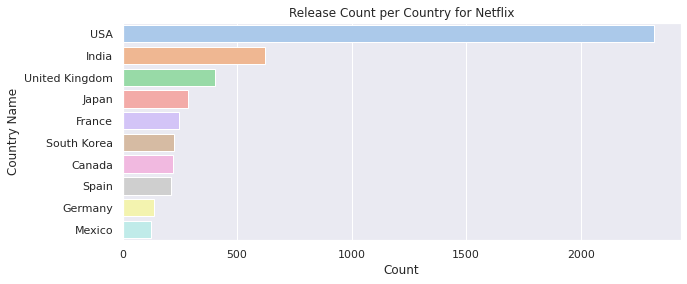

In [ ]:
sns.set(rc={"figure.figsize":(10, 4)}) #width=10, height=4
g = sns.barplot(df_release_num["count"], df_release_num["country_name"],palette = 'pastel')
g.set(xlabel='Count',
       ylabel='Country Name',
       title='Release Count per Country for Netflix')
#display barplot
plt.show()

In [ ]:
# # instead of using SQL, here is the code of using pandas directly 
# # downwards is the code of using pandas libraries

# df_netflix_country = df_netflix[['country_US', 'country_IN',
#        'country_GB', 'country_JP', 'country_FR', 'country_KR', 'country_CA',
#        'country_ES', 'country_DE', 'country_MX']] 

# # Sum each column:
# df_netflix_country_agg = df_netflix_country.sum(axis=0)
# df_netflix_country_agg

# import seaborn as sns
# sns.set(rc={"figure.figsize":(8, 4)}) #width=8, height=4
# g = sns.barplot(df_netflix_country_agg.values, df_netflix_country_agg.index,
#                 palette = 'pastel').set(title='Release Count per Country for Netflix')

# d5: A summary of the key findings

### Q1: What is the count of movies and TV shows across different service providers (different datasets)?

In [ ]:
source = ColumnDataSource(data=data_movie_show)
output_notebook()
p = figure(x_range=product_type_col, y_range=(0, 9000), title="Release Counts per Product Type per Service Provider",
           height=380, width=600)

labels15=LabelSet(x=dodge('product_type_col', -0.3, range=p.x_range),y='Netflix',text='Netflix',source=source,text_align='center')
labels16=LabelSet(x=dodge('product_type_col', -0.1, range=p.x_range),y='HBO',text='HBO',source=source,text_align='center')
labels17=LabelSet(x=dodge('product_type_col', 0.1, range=p.x_range),y='Amazon',text='Amazon',source=source,text_align='center')
labels18=LabelSet(x=dodge('product_type_col', 0.3, range=p.x_range),y='Disney',text='Disney',source=source,text_align='center')

p.vbar(x=dodge('product_type_col', -0.3, range=p.x_range), top='Netflix', source=source,
       width=0.18, color="#FED049", legend_label="Netflix")

p.vbar(x=dodge('product_type_col', -0.1,  range=p.x_range), top='HBO', source=source,
       width=0.18, color="#CFFDE1", legend_label="HBO")

p.vbar(x=dodge('product_type_col',  0.1, range=p.x_range), top='Amazon', source=source,
       width=0.18, color="#68B984", legend_label="Amazon")

p.vbar(x=dodge('product_type_col',  0.3, range=p.x_range), top='Disney', source=source,
       width=0.18, color="#3D5656", legend_label="Disney")

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"

p.add_layout(labels15)
p.add_layout(labels16)
p.add_layout(labels17)
p.add_layout(labels18)

p.yaxis.axis_label = 'Release Count'
p.xaxis.axis_label = 'Product Type'

show(p)

From the diagram, we know across different stream providers the number of movie productions is significantly higher than the TV Shows.

### Q2: What are the best comedy movies in each dataset? (Find the top five IMDB Rating comedy movies in each dataset)

In [ ]:
print("Netflix top 5 comedy movie by IMDB rating : ")
df_top5_comedy_netflix.rename(columns = {'title' :'Title', 'release_year' :'Release Year', 'imdb_score' :'IMDB Score'}, inplace = True)
display(df_top5_comedy_netflix)
print("---------------------------------------------------------------------")
print("HBO top 5 comedy movie by IMDB rating : ")
df_top5_comedy_hbo.rename(columns = {'title' :'Title', 'release_year' :'Release Year', 'imdb_score' :'IMDB Score'}, inplace = True)
display(df_top5_comedy_hbo)
print("---------------------------------------------------------------------")
print("Amazon top 5 comedy movie by IMDB rating : ")
df_top5_comedy_amazon.rename(columns = {'title' :'Title', 'release_year' :'Release Year', 'imdb_score' :'IMDB Score'}, inplace = True)
display(df_top5_comedy_amazon)
print("---------------------------------------------------------------------")
print("Disney top 5 comedy movie by IMDB rating : ")
df_top5_comedy_disney.rename(columns = {'title' :'Title', 'release_year' :'Release Year', 'imdb_score' :'IMDB Score'}, inplace = True)
display(df_top5_comedy_disney)

Netflix top 5 comedy movie by IMDB rating : 


,Title,Release Year,IMDB Score
0,Anbe Sivam,2003,8.70
1,Bo Burnham: Inside,2021,8.70
2,Bill Hicks: Revelations,1993,8.50
3,3 Idiots,2009,8.40
4,Louis C.K.: Hilarious,2010,8.40


---------------------------------------------------------------------
HBO top 5 comedy movie by IMDB rating : 


,Title,Release Year,IMDB Score
0,Emergency Contact,2015,9.20
1,Dave Chappelle: Killin' Them Softly,2000,8.80
2,George Carlin: Jammin' in New York,1992,8.70
3,City Lights,1931,8.50
4,George Carlin: You Are All Diseased,1999,8.50


---------------------------------------------------------------------
Amazon top 5 comedy movie by IMDB rating : 


,Title,Release Year,IMDB Score
0,Alexander Babu: Alex in Wonderland,2019,9.20
1,Steven Banks: Home Entertainment Center,1989,9.10
2,The Mission,2021,9.00
3,Florence Foster Jenkins,2016,8.90
4,Mitzi... Zings Into Spring,1977,8.90


---------------------------------------------------------------------
Disney top 5 comedy movie by IMDB rating : 


,Title,Release Year,IMDB Score
0,Coco,2017,8.40
1,Toy Story 3,2010,8.30
2,Up,2009,8.30
3,Toy Story,1995,8.30
4,Inside Out,2015,8.20


### Q3: What is the trend of release number for all the productions in each dataset from 1980 to 2022?

In [ ]:
output_notebook()
p = figure(height=350, width=800, x_axis_label="x", y_axis_label="y",
           title = "Release Count per Year per Service Provider")

p.line(df_release_num_netflix['release_year'], df_release_num_netflix['release_count'], legend_label="Netflix", color="#FED049", line_width=5) #note use of hex codes.
p.line(df_release_num_hbo['release_year'], df_release_num_hbo['release_count'], legend_label="HBO", color="#CFFDE1", line_width=5) #note use of hex codes.
p.line(df_release_num_amazon['release_year'], df_release_num_amazon['release_count'], legend_label="Amazon", color="#68B984", line_width=5) #note use of hex codes.
p.line(df_release_num_disney['release_year'], df_release_num_disney['release_count'], legend_label="Disney", color="#3D5656", line_width=5) #note use of hex codes.

p.add_tools(HoverTool(tooltips=[("Year", "@x"), ("Count", "@y")]))

p.yaxis.axis_label = 'Release Count'
p.xaxis.axis_label = 'Releasing Year'

p.legend.location = "top_left"
show(p)

Across all the providers, the release trend is quite flat from 1980 to 2010. The release count from Netflix and Amazon have surged after 2014. The count in 2022 is significantly lower than the year before, the reason may be because the data is updated in May/July 2022.

### Q4: What is the mean IMDB score for comedy across different provider (in various datasets)?

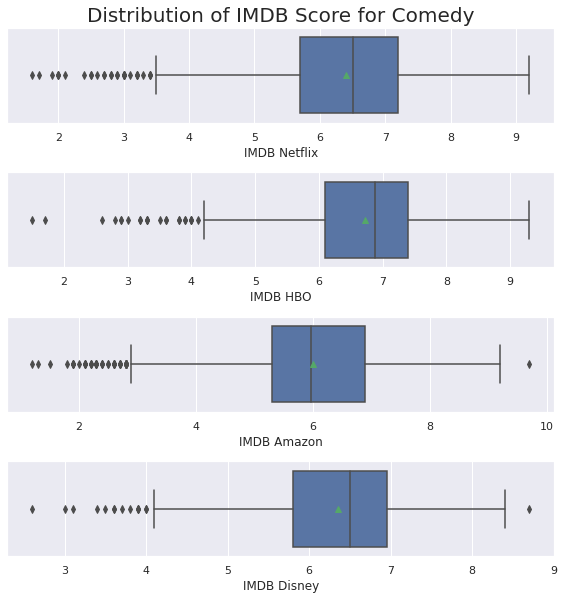

In [ ]:
plt.figure(figsize = (8, 8.5))
plt.subplot(4,1,1)
plt.title('Distribution of IMDB Score for Comedy', fontsize=20)
sns.boxplot(df_IMDB_Netflix['IMDB Netflix'], showmeans=True)
# .set(title='Distribution of IMDB Score for Comedy')
plt.subplot(4,1,2)
sns.boxplot(df_IMDB_HBO['IMDB HBO'], showmeans=True)
plt.subplot(4,1,3)
sns.boxplot(df_IMDB_Amazon['IMDB Amazon'], showmeans=True)
plt.subplot(4,1,4)
sns.boxplot(df_IMDB_Disney['IMDB Disney'], showmeans=True)

plt.tight_layout()

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame.from_dict(IMDB_mean_dict)

,Stream Provider,IMDB Score
0,IMDB Netflix,6.40
1,IMDB HBO,6.72
2,IMDB Amazon,6.00
3,IMDB Disney,6.35


### Q5: What is the Total Release number per Country by Netflix?

In [ ]:
country_name_list = list(df["country_name"])
counts = list(df["count"])

source = ColumnDataSource(data=dict(country_name_list=country_name_list, counts=counts, color=PuOr[10]))

p = figure(x_range=country_name_list, y_range=(0,2500), height=400, width=1000, title="Total Netflix Release Number per Country")

p.vbar(x='country_name_list', top='counts', width=0.9, color='color', legend_field="country_name_list", source=source)
p.add_tools(HoverTool(tooltips=[("Country", "@country_name_list"), ("Total", "@counts")]))

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_right"

p.yaxis.axis_label = 'Release Count'
p.xaxis.axis_label = 'Country Name'

show(p)

The Netflix productions from the USA is significantly higher than all the other countries. 

# Future Research

1. From the result of Q3, I guess the subscriber number of Amazon and Netflix after 2014 greatly increased. If I obtain the data of subscriber number per year, I can further study the relation of subscriber number and the release number.
2. Similar as Q2, a recommendation watching list based on IMDB score can be built. By entering a specific genre and type of product (movie/ show), the list can be automatically created.
3. Further study what's the factors that influence the IMDB score, and find the most correlated feature.